In [215]:
import random as rn
rn.seed(1254)

import numpy as np
np.random.seed(1515)

import h5py
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import tensorflow as tf
tf.set_random_seed(2)

config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
from keras.models import load_model
K.set_learning_phase(1)

In [2]:
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
projectspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'
#modelpath = os.path.join(projectspace,'models','crnn_epoch_156_val_loss_1.3890.hdf5')
modelpath = os.path.join(projectspace,'models','cnn_epoch_032_val_loss_1.5498.hdf5')
hdf5_path = os.path.join(projectspace,'dataset.hdf5')

In [4]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [5]:
model=load_model(modelpath)

In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict.keys()

[u'dense_1',
 u'flatten_1',
 u'max_pooling2d_1',
 u'max_pooling2d_3',
 u'max_pooling2d_2',
 u'dropout_1',
 u'input_1',
 u'batch_normalization_2',
 u'batch_normalization_3',
 u'batch_normalization_1',
 u'conv2d_1',
 u'conv2d_3',
 u'conv2d_2']

In [125]:
layer_name = 'conv2d_3'
step = 1

In [11]:
input_data = model.input

In [126]:
filter_index = range(10,20)
gen_im=[]
layer_output = layer_dict[layer_name].output

for f in filter_index:
    loss = K.mean(layer_output[:, :, :, f],)
    
    grads = 0
    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_data)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_data], [loss, grads])
    
    input_data_gen = np.random.random((1, n_frames, n_features, 1))
    for i in range(10):
        loss_value, grads_value = iterate([input_data_gen])
        input_data_gen += grads_value * step
        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
           # some filters get stuck to 0, we can skip them
            break
    gen_im.append(input_data_gen)

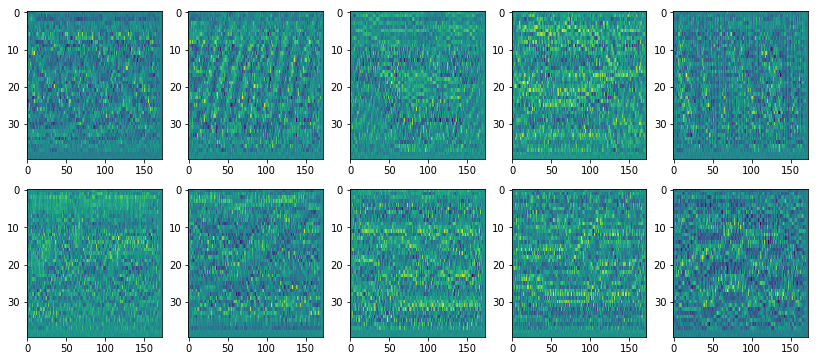

In [129]:
fig = plt.figure()
for idx, im in enumerate(gen_im):
    plt.subplot(2,5,idx+1)
    plt.imshow(deprocess_image(im[0,:,:,0]).T, aspect='auto')

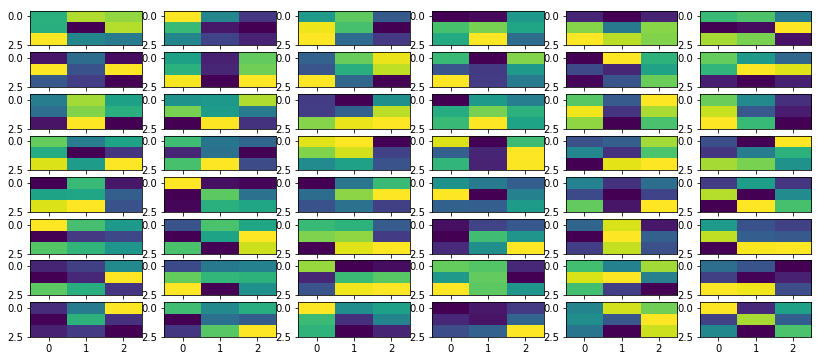

In [46]:
filters=model.get_weights()[0]
fig=plt.figure()
for idx in range(0,filters.shape[3]):
    #print(idx)
    plt.subplot(8,6,idx+1)

    im = plt.imshow(filters[:,:,0,idx], aspect='auto')

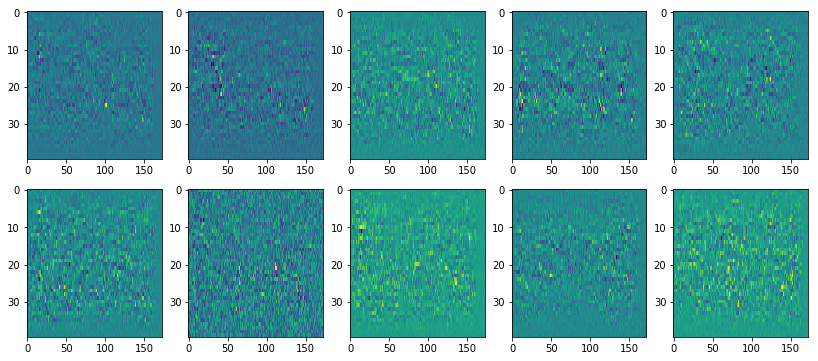

In [131]:
max_output=[]

for out in range(0,10):
    loss = K.mean(model.output[:, out])
    
    grads = 0
    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_data)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # this function returns the loss and grads given the input picture
    iterate = K.function([input_data], [loss, grads])
    
    input_data_gen = np.random.random((1, n_frames, n_features, 1))
    for i in range(100):
        loss_value, grads_value = iterate([input_data_gen])
        input_data_gen += grads_value * step
        #print('Current loss value:', loss_value)
        #print('Current grad value:', grads_value)
        if loss_value <= 0:
           # some filters get stuck to 0, we can skip them
            break
    max_output.append(input_data_gen)

fig = plt.figure()
for idx, im in enumerate(max_output):
    plt.subplot(2,5,idx+1)
    plt.imshow(im[0,:,:,0].T, aspect='auto')

In [99]:
prediction = model.predict(np.squeeze(np.array(max_output),axis=1), batch_size=10, verbose=1)
print(prediction)
print(prediction.argmax(axis=0))

10/10 [==============================] - 0s 593us/step
[[  1.00000000e+00   9.89177406e-01   7.09958851e-01   9.99133527e-01
    9.99514937e-01   8.87930691e-01   9.99974728e-01   9.91948366e-01
    9.99997497e-01   9.94733453e-01]
 [  9.99996066e-01   1.00000000e+00   8.23610663e-01   9.99998450e-01
    9.99999285e-01   2.09986627e-01   9.99927878e-01   6.25829160e-01
    7.96871841e-01   9.99997258e-01]
 [  7.61402786e-01   9.71029222e-01   1.00000000e+00   9.99876142e-01
    9.91870761e-01   2.44341582e-01   9.99785602e-01   9.93217647e-01
    9.90948141e-01   9.62350011e-01]
 [  9.99989986e-01   9.95496154e-01   9.76613909e-02   1.00000000e+00
    9.99973178e-01   7.71456491e-03   9.98933494e-01   9.40551102e-01
    9.67565238e-01   1.21822983e-01]
 [  9.99987960e-01   9.99915361e-01   6.40938878e-02   9.99994278e-01
    1.00000000e+00   1.27570704e-01   9.99952197e-01   9.64915097e-01
    9.43372726e-01   9.99613225e-01]
 [  9.06947434e-01   1.31865159e-01   9.28501606e-01   9.996

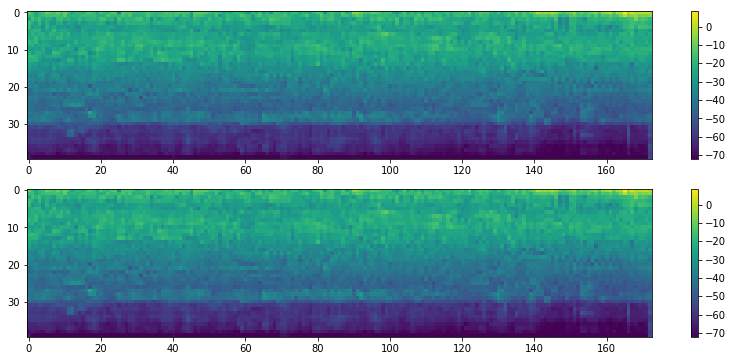

In [190]:
loss = K.mean(model.output[:, ])

grads = 0
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_data)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_data], [loss, grads])

input_spec = X_test[0].T
input_data_gen = np.expand_dims(input_spec, 0)
input_data_gen = np.expand_dims(input_data_gen, 3)
for i in range(500):
    loss_value, grads_value = iterate([input_data_gen])
    input_data_gen += grads_value * step
    #print('Current loss value:', loss_value)
    #print('Current grad value:', grads_value)
    if loss_value <= 0:
       # some filters get stuck to 0, we can skip them
        break
f=plt.figure()
plt.subplot(2,1,1)
plt.imshow(input_spec.T, aspect='auto')
plt.colorbar()
plt.subplot(2,1,2)
plt.imshow(input_data_gen[0,:,:,0].T, aspect='auto')
plt.colorbar()

In [313]:
predictionASCENT = model.predict(input_data_gen, batch_size=1, verbose=1)
print(predictionASCENT)
prediction = model.predict(np.expand_dims(np.expand_dims(X_test[1].T,0),3), batch_size=1, verbose=1)
print(prediction)
print(y_test[1])
print(np.argmax(prediction))

1/1 [==============================] - 0s 5ms/step
[[ 0.64992166  0.99763334  0.23289925  0.99579901  1.          0.8864994
   0.62606972  0.99999976  1.          0.57665932]]
1/1 [==============================] - 0s 3ms/step
[[  2.41978467e-02   3.26797068e-02   6.89058083e-07   2.16159895e-02
    2.15280871e-03   2.81461865e-01   4.21969444e-02   5.77420115e-01
    2.85361856e-01   1.77567056e-03]]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
7
